In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from numpy.linalg import inv, eig
from sklearn.base import BaseEstimator
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
try:
    import statsmodels.api.add_constant
except ImportError:
    pass

In [2]:
ozone = pd.read_csv('ozone.csv')

In [3]:
n = ozone.shape[0]

#Loading data
X = ozone.drop(columns=['ozone']).to_numpy()
Y = ozone['ozone'].to_numpy()

# Center data
Y_centered = Y - np.mean(Y)
X_centered = X - np.mean(X, axis=0)

# Standardize X (centered and scaled)
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

#Feature names
colnames = ozone.columns[1:9]
colnames

Index(['temp', 'invHt', 'press', 'vis', 'milPress', 'hum', 'invTemp', 'wind'], dtype='object')

# Feature Selection - Algorithmic

#### Best subsets

In [4]:
# Define a linear regression model
linear_reg = LinearRegression()

#Obtain exhaustive mse values
efs = EFS(
    linear_reg,
    min_features=1, 
    max_features=8,
    scoring="neg_mean_squared_error", #we use negative mse since the sfs method maximizes the score 
    cv=0
)
efs.fit(X, Y)

#Obtain a summary of the exhaustive results (all possible models)
efs_summary = pd.DataFrame.from_dict(efs.get_metric_dict()).T[["feature_idx", "avg_score"]]
efs_summary["feature_idx"]
efs_size = np.zeros(len(efs_summary))
for i in range(len(efs_summary)):
    efs_size[i] = len(efs_summary["feature_idx"][i])
efs_summary['model size'] = efs_size
efs_summary.rename(columns={'avg_score': 'neg_mse'}, inplace=True)
print("The first few results for exhaustive feature selection (all possible models) look like:")
print(efs_summary.iloc[range(15)].to_string(index=False))

Features: 255/255/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The first few results for exhaustive feature selection (all possible models) look like:
feature_idx    neg_mse  model size
       (0,) -24.986761         1.0
       (1,) -41.747684         1.0
       (2,) -61.054502         1.0
       (3,) -51.542597         1.0
       (4,) -40.383759         1.0
       (5,) -51.073548         1.0
       (6,) -28.417062         1.0
       (7,) -63.974566         1.0
     (0, 1) -22.291623         2.0
     (0, 2)  -24.69501         2.0
     (0, 3) -23.546491         2.0
     (0, 4) -24.884852         2.0
     (0, 5) -22.551957         2.0
     (0, 6)  -23.72773         2.0
     (0, 7) -24.978107         2.0


In [5]:
#code to calculate model evaluation criteria for all models in efs_summary

#code to calculate sigma hat squared for Mallows Cp calculation
X_with_const = sm.tools.tools.add_constant(X)
model = sm.regression.linear_model.OLS(Y, X_with_const).fit()
sigma_hat_squared = np.sum(model.resid ** 2) / (len(Y) - len(X[0])) #intercept not counted as predictor
#code to calculate total sum of squares, used for r2 calculation:
Y_mean = np.mean(Y)
tss = sum((Y - np.full(len(Y), Y_mean))**2)

prederror = np.zeros((len(efs_summary),4))
for i in range(len(efs_summary)):
    rss = -efs_summary.iloc[i,1]*len(X)
    p = efs_summary.iloc[i,2]
    n = len(X)
    aic = 2*p + n * np.log(rss/n)
    bic = p * np.log(n) + n * np.log(rss/n)
    mallows_cp = (rss / sigma_hat_squared) - n + 2 * p
    r2 = 1 - rss/tss
    adjr2 = 1 - (1 - r2)*(n-1)/(n-p-1)
    prederror[i,0] = bic
    prederror[i,1] = adjr2
    prederror[i,2] = mallows_cp
    prederror[i,3] = aic

efs_summary['bic'] = prederror[:,0]
efs_summary['adjr2'] = prederror[:,1]
efs_summary['cp'] = prederror[:,2]
efs_summary['aic'] = prederror[:,3]
print(efs_summary.iloc[0:15,:].to_string(index=False))

feature_idx    neg_mse  model size         bic     adjr2         cp         aic
       (0,) -24.986761         1.0 1067.853316  0.608306  79.224535 1064.054223
       (1,) -41.747684         1.0 1237.241609  0.345561 352.387557 1233.442516
       (2,) -61.054502         1.0 1362.682182  0.042907 667.042572 1358.883089
       (3,) -51.542597         1.0 1306.793927  0.192016 512.021238 1302.994835
       (4,) -40.383759         1.0 1226.280233  0.366942 330.158829 1222.481140
       (5,) -51.073548         1.0 1303.777107  0.199369 504.376859 1299.978014
       (6,) -28.417062         1.0 1110.305705  0.554533 135.130245 1106.506613
       (7,) -63.974566         1.0 1378.099342 -0.002868 714.632652 1374.300250
     (0, 1) -22.291623         2.0 1035.987804  0.649487  37.300222 1028.389619
     (0, 2)  -24.69501         2.0 1069.776582  0.611696  76.469688 1062.178396
     (0, 3) -23.546491         2.0 1054.060526  0.629755  57.751564 1046.462340
     (0, 4) -24.884852         2.0 1072.

In [6]:
best_model = [None] * 3
best_model[0] = efs_summary.iloc[int(efs_summary['bic'].idxmin()),0]
best_model[1] = efs_summary.iloc[int(efs_summary['adjr2'].idxmax()),0]
best_model[2] = efs_summary.iloc[int(efs_summary['cp'].idxmin()),0]
best_model_display = pd.DataFrame([best_model], columns=["BIC", "Adj R2", "CP"])
print(best_model_display.to_string(index=False))

      BIC             Adj R2                 CP
(0, 1, 5) (0, 1, 3, 4, 5, 6) (0, 1, 3, 4, 5, 6)


In [7]:
print("The best model for each criterion is:")
print("BIC: " + str(np.array(colnames)[np.array(best_model_display['BIC'][0])]))
print("Adj R2: " + str(np.array(colnames)[np.array(best_model_display['Adj R2'][0])]))
print("Cp: " + str(np.array(colnames)[np.array(best_model_display['CP'][0])]))

The best model for each criterion is:
BIC: ['temp' 'invHt' 'hum']
Adj R2: ['temp' 'invHt' 'vis' 'milPress' 'hum' 'invTemp']
Cp: ['temp' 'invHt' 'vis' 'milPress' 'hum' 'invTemp']


#### Stepwise variable selection based on AIC

In [8]:
#defining aic evaluation functions compatible with mlxtend.feature_selection.SequentialFeatureSelector
def calculate_aic(estimator, X, y):
    """
    Custom AIC scorer for SequentialFeatureSelector.
    Args:
        estimator: A fitted sklearn-compatible estimator.
        X: Features (numpy array).
        y: Target variable (numpy array).
    Returns:
        Negative AIC value for compatibility with SFS (higher is better).
    """
    n, k = X.shape  # n: number of samples, k: number of predictors
    y_pred = estimator.predict(X)
    residual_sum_of_squares = np.sum((y - y_pred) ** 2)
    aic = n * np.log(residual_sum_of_squares / n) + 2 * k
    return -aic  # SFS maximizes the score

def aic_scorer_wrapper(estimator, X, y):
    estimator.fit(X, y)
    return calculate_aic(estimator, X, y)

In [9]:
model = LinearRegression()
sfs_forward = SFS(
    model,
    k_features='best',
    forward=True,
    floating=False,
    scoring=aic_scorer_wrapper,  # Use custom AIC scorer
    cv=0  # No cross-validation, evaluate on the whole dataset
)

sfs_forward.fit(X_standardized,Y_centered)

print("Selected features:", np.array(colnames)[np.array(sfs_forward.k_feature_names_, dtype=int)])
print(pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T[["feature_idx", "avg_score"]])

Selected features: ['temp' 'invHt' 'vis' 'milPress' 'hum' 'invTemp']
                feature_idx    avg_score
1                      (0,) -1064.054223
2                    (0, 1) -1028.389619
3                 (0, 1, 5)    -998.2249
4              (0, 1, 3, 5)  -997.197487
5           (0, 1, 3, 5, 6)  -997.090405
6        (0, 1, 3, 4, 5, 6)  -996.925025
7     (0, 1, 3, 4, 5, 6, 7)   -998.58561
8  (0, 1, 2, 3, 4, 5, 6, 7) -1000.565877


/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
model = LinearRegression()
sfs_backward = SFS(
    model,
    k_features='best',
    forward=False,
    floating=False,
    scoring=aic_scorer_wrapper,  # Use custom AIC scorer
    cv=0  # No cross-validation, evaluate on the whole dataset
)

sfs_backward.fit(X_standardized,Y_centered)

print("Selected features:", np.array(colnames)[np.array(sfs_backward.k_feature_names_, dtype=int)])
print(pd.DataFrame.from_dict(sfs_backward.get_metric_dict()).T[["feature_idx", "avg_score"]])

Selected features: ['temp' 'invHt' 'vis' 'milPress' 'hum' 'invTemp']
                feature_idx    avg_score
8  (0, 1, 2, 3, 4, 5, 6, 7) -1000.565877
7     (0, 1, 3, 4, 5, 6, 7)   -998.58561
6        (0, 1, 3, 4, 5, 6)  -996.925025
5           (0, 1, 3, 5, 6)  -997.090405
4              (0, 1, 3, 5)  -997.197487
3                 (0, 1, 5)    -998.2249
2                    (0, 1) -1028.389619
1                      (0,) -1064.054223


/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# L1 Regularization (Lasso)

Let's observe how coefficients differ when using OLS vs Lasso. Observe that Lasso results in 0 coefficients for some parameters:

In [11]:
fit0 = LinearRegression()
fit0.fit(X_standardized, Y_centered)

lasso = Lasso(fit_intercept=False)
lasso.fit(X_standardized, Y_centered)
print(pd.DataFrame(np.stack((colnames, fit0.coef_, lasso.coef_), axis=1), columns=["Variables", "Without L1","With L1"]))

  Variables Without L1   With L1
0      temp   3.954079  3.495097
1     invHt  -0.957115 -0.661984
2     press   0.056038       0.0
3       vis  -0.518378 -0.001146
4  milPress  -0.724833       0.0
5       hum   1.395777  0.993261
6   invTemp   1.948347  1.224387
7      wind   0.154378       0.0


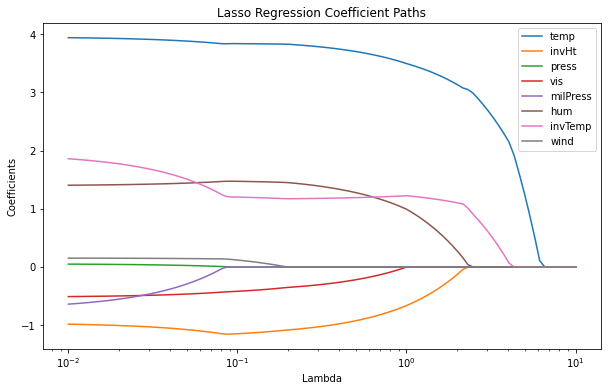

In [12]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
betasl = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    lasso = Lasso(alpha = lamb)
    lasso.fit(X_standardized, Y_centered)
    betasl[i, :] = lasso.coef_

# Plot Lasso paths (log-scale)
plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]): #for each variable
    plt.plot(lambdas, betasl[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Lasso Regression Coefficient Paths")
plt.legend(colnames)
plt.show()

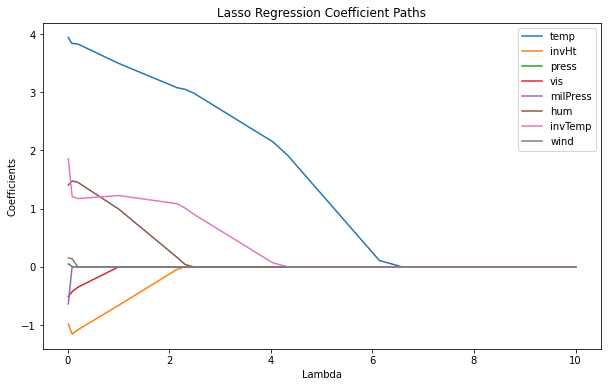

In [13]:
# Plot Lasso paths
plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]): #for each variable
    plt.plot(lambdas, betasl[:, j], label=f"Variable {j+1}")
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Lasso Regression Coefficient Paths")
plt.legend(colnames)
plt.show()

# L2 Regularization (Ridge) and Elastic Net

ElasticNet is a mix between Ridge and Lasso. The quantity L1Ratio represents the ratio of the L1 regularization parameter to the L2 regularization parameter, with l1ratio=0 representing Ridge and l1ratio=1 representing Lasso

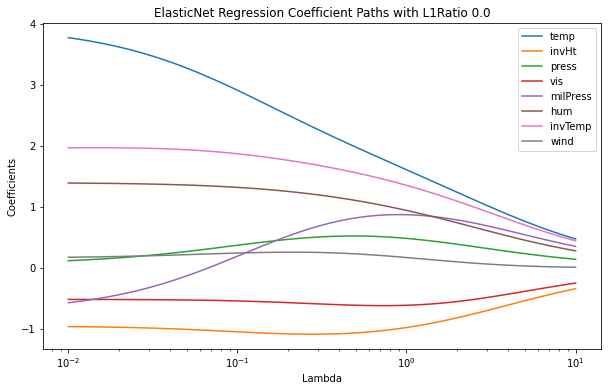

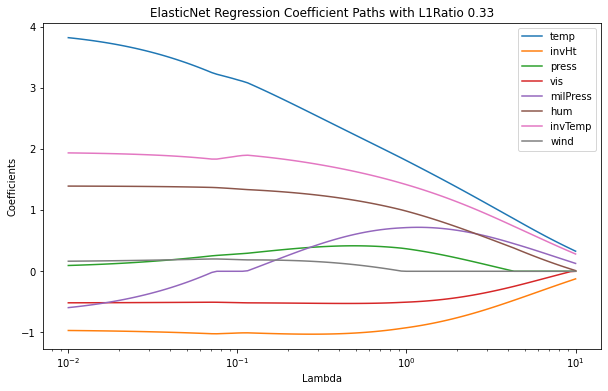

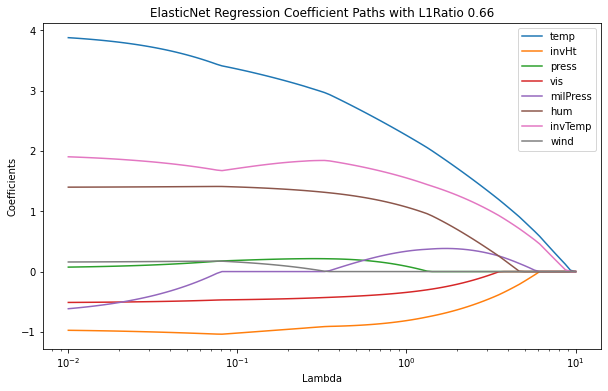

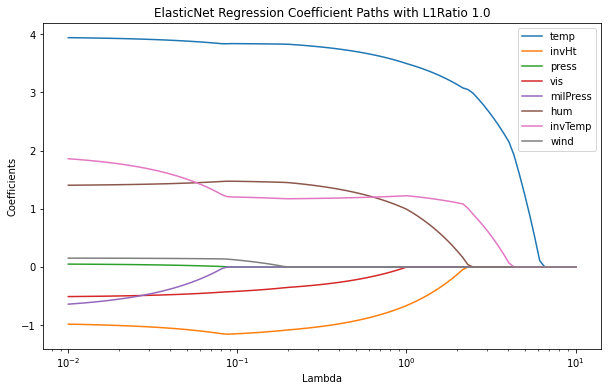

In [14]:
import warnings
warnings.filterwarnings("ignore")

lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
l1ratios = np.array([0, 0.33, 0.66, 1])
coefs = pd.DataFrame()
for l1ratio in l1ratios:
    betase = np.zeros((len(lambdas), X.shape[1]))
    for i, lamb in enumerate(lambdas):
        elasticnet = ElasticNet(alpha=lamb, l1_ratio = l1ratio, fit_intercept=False)
        elasticnet.fit(X_standardized, Y_centered)
        betase[i, :] = elasticnet.coef_

    # Plot Lasso paths (log-scale)
    plt.figure(figsize=(10, 6))
    for j in range(X_standardized.shape[1]): #for each variable
        plt.plot(lambdas, betase[:, j], label=f"Variable {j+1}")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Coefficients")
    plt.title("ElasticNet Regression Coefficient Paths with L1Ratio " + str(l1ratio))
    plt.legend(colnames)
    plt.show()
    elasticnet = ElasticNet(alpha=1, l1_ratio = l1ratio, fit_intercept=False)
    elasticnet.fit(X_standardized, Y_centered)
    coefs[l1ratio] = elasticnet.coef_

In [15]:
coefs_df = pd.DataFrame(coefs)
coefs_df.insert(0, 'Variables', colnames)
print("The coefficients of each l1ratio at regularization parameter 1 are")
print(coefs_df.to_string(index=False))

The coefficients of each l1ratio at regularization parameter 1 are
Variables       0.0      0.33      0.66       1.0
     temp  1.605254  1.809182  2.256907  3.495097
    invHt -0.980377 -0.922969 -0.812907 -0.661984
    press  0.480175  0.367790  0.087163  0.000000
      vis -0.615595 -0.505016 -0.344862 -0.001146
 milPress  0.868272  0.714426  0.337005  0.000000
      hum  0.938469  0.982854  1.068833  0.993261
  invTemp  1.349336  1.416246  1.551108  1.224387
     wind  0.166292  0.000000  0.000000  0.000000
